# Synthetic Validation

## Import Statement :

First make sure you have installed pandas and ipyvolume

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import cv2, collections, numpy, math, pandas

import multiprocessing
import cv2
import sys
import numpy
import os
import math
import pandas

import openalea.phenomenal.object as phm_obj
import openalea.phenomenal.mesh as phm_mesh
import openalea.phenomenal.segmentation as phm_seg
import openalea.phenomenal.display.notebook as phm_display_notebook
import openalea.phenomenal.data as phm_data

## 1. Import McCormik data

### 1.1 Select plant_number

In [2]:
vertices, faces, colors = phm_data.mesh_mccormik_plant("data/mccormick_plant_2") # only 1 or 2 available
colors = colors[:, :3].astype(float) / 255.0

### 1.2 Viewing

In [3]:
phm_display_notebook.show_mesh(vertices, faces, color=colors)

## 2. Phenomenal Measurements

### 2.1 Voxelization

In [4]:
voxels_size = 4.0
voxels_position = phm_mesh.from_vertices_faces_to_voxels_position(
    vertices, faces, voxels_size=voxels_size)
voxels_position = numpy.array(voxels_position)
voxel_grid = phm_obj.VoxelGrid(voxels_position, voxels_size)

### 1.2 Viewing

In [5]:
phm_display_notebook.show_voxel_grid(voxel_grid, size=0.4)

### 2.3 Skeletonization

In [6]:
graph = phm_seg.graph_from_voxel_grid(voxel_grid)
src_node = tuple(phm_seg.find_base_stem_position(graph.nodes(), 
                                                 voxel_grid.voxels_size, 
                                                 neighbor_size=45))

voxel_skeleton = phm_seg.skeletonize(voxel_grid, graph, src_node)
# Display it
phm_display_notebook.show_skeleton(voxel_skeleton, with_voxel=True, size=0.4)

### 2.4 Cereals Segmentation

In [7]:
vms = phm_seg.maize_segmentation(voxel_skeleton, graph)
vmsi = phm_seg.maize_analysis(vms)

In [8]:
# Phenomenal measurements of each organs
pm_rows = [vo.info for vo in vmsi.voxel_organs]  + [vmsi.info]

In [9]:
# Display it
phm_display_notebook.show_segmentation(vmsi, size=0.4)

## 3. McCormik measurement

In [10]:
stem_color = (0, 1, 1)
index = numpy.apply_along_axis(numpy.array_equal, 1, colors, stem_color)
v = vertices[index]

mccm_rows = list()
row = dict()
row['mccm_label'] = "plant"
row['mccm_number_of_leaf'] = len(set(map(tuple, colors))) - 1
mccm_rows.append(row)

row = dict()
row['mccm_label'] = "stem"
row['mccm_length'] = numpy.max(v[:, 2]) - numpy.min(v[:, 0])
mccm_rows.append(row)

## 4. Measures registration

In [11]:
def registration_row(pm_rows, sm_rows):

    def same_label(pm_row, sm_row):
        for label in ["stem", "plant"]:
            if pm_row["pm_label"] == label and sm_row["mccm_label"] == label:
                return True
        return False

    registered_row = list()
    for pm_row in pm_rows:
        for sm_row in sm_rows:

            if same_label(pm_row, sm_row):
                registered_row.append((pm_row, sm_row, 0))
                continue
            else:
                continue

    return registered_row

In [12]:
labels = ["pm_label", "pm_length", "pm_number_of_leaf"]

rows = list()
for pm_row, mccm_row, d in registration_row(pm_rows, mccm_rows):
    for label in labels:
        if label in pm_row:
            mccm_row[label] = pm_row[label]
    rows.append(mccm_row)
            
df = pandas.DataFrame(rows)

## 5. Measures Comparison

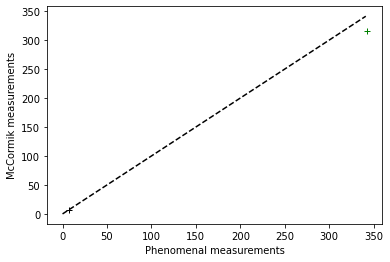

In [13]:
df_filtred_label = df[df["pm_label"] == "stem"]
plt.plot(df_filtred_label["mccm_length"], df_filtred_label["pm_length"], "g+")
df_filtred_label = df[df["pm_label"] == "plant"]
plt.plot(df_filtred_label["mccm_number_of_leaf"], df_filtred_label["pm_number_of_leaf"], "k+")

plt.xlabel("Phenomenal measurements")
plt.ylabel("McCormik measurements")

m = int(max([df[k].max() for k in ["pm_length", "mccm_length"]]))

plt.plot(range(m), range(m), 'k--')